In [8]:
# -------------------------
# 0️⃣ Requirements & imports
# -------------------------
!pip install torch torchvision timm scikit-learn tqdm seaborn tabulate --quiet

import os, random, csv, time, tarfile, zipfile, math
from pathlib import Path
from collections import OrderedDict
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

from sklearn.metrics import accuracy_score, top_k_accuracy_score, confusion_matrix
from tabulate import tabulate

In [ ]:
# ---------------------------
# Mount Google Drive & extract dataset
# ---------------------------
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = "/content/drive/MyDrive/ML_Proj_2"
DATA_ZIP = os.path.join(BASE_DIR, "AML_project_herbarium_dataset.zip")
DATA_DIR = os.path.join(BASE_DIR, "AML_project_herbarium_dataset")

# Extract dataset
if not os.path.exists(DATA_DIR):
    with zipfile.ZipFile(DATA_ZIP, 'r') as zip_ref:
        zip_ref.extractall(BASE_DIR)
    print("✅ Dataset extracted")
else:
    print("📁 Dataset already exists")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📁 Dataset already exists


In [10]:
# -------------------------
# 1️⃣ User configs (edit as desired)
# -------------------------
BASE_DIR = "/content/drive/MyDrive/ML_Proj_2"
DATA_DIR = os.path.join(BASE_DIR, "AML_project_herbarium_dataset")
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR  = os.path.join(DATA_DIR, "test")
LIST_DIR  = os.path.join(DATA_DIR, "list")

SPECIES_LIST_FILE = os.path.join(LIST_DIR, "species_list.txt")
GROUNDTRUTH_FILE   = os.path.join(LIST_DIR, "groundtruth.txt")
WITH_PAIRS_FILE    = os.path.join(LIST_DIR, "class_with_pairs.txt")
WITHOUT_PAIRS_FILE = os.path.join(LIST_DIR, "class_without_pairs.txt")

PRETRAINED_ARCHIVE = os.path.join(BASE_DIR, "dinov2_patch14_reg4_onlyclassifier_then_all-pytorch-default-v3.tar.gz")
EXTRACTED_DIR = os.path.join(BASE_DIR, "dinov2_ckpt/extracted")
CHECKPOINT_DIR = os.path.join(BASE_DIR, "dino_checkpoints")
EMBEDDINGS_DIR = os.path.join(BASE_DIR, "dino_embeddings")
PLOTS_DIR = os.path.join(BASE_DIR, "dino_plots")

os.makedirs(EXTRACTED_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(EMBEDDINGS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

# Training policy
NUM_CLASSES = 100          # dataset classes
IMG_SIZE = 224
BATCH_SIZE = 32            # will auto-reduce on CPU if necessary
NUM_WORKERS = 2
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# Stage schedule
HEAD_EPOCHS = 3            # Stage1: head-only epochs
FINETUNE_EPOCHS = 9       # Stage2: unfreeze last K blocks and train further
UNFREEZE_BLOCKS = 2        # number of ViT transformer blocks to unfreeze in Stage2 (last N)
FULL_UNFREEZE = False      # If True you can unfreeze whole model after Stage2
LR_HEAD = 1e-3             # learning rate for head-only stage
LR_FINETUNE = LR_HEAD * 0.1  # lower LR for partial unfreeze
WEIGHT_DECAY = 1e-4
USE_AMP = True

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# If running on CPU, reduce batch size to avoid OOM/slow
if DEVICE.type == "cpu" and BATCH_SIZE > 8:
    print("CPU detected — lowering BATCH_SIZE to 8 for stability")
    BATCH_SIZE = 8

Device: cuda


In [11]:
# -------------------------
# 2️⃣ Utility functions
# -------------------------
def safe_extract_tar(archive_path, dest_dir):
    # extract tar.gz safely
    if not os.listdir(dest_dir):
        with tarfile.open(archive_path, "r:gz") as tar:
            tar.extractall(path=dest_dir)
        print("✅ Pretrained checkpoint extracted to:", dest_dir)
    else:
        print("📁 Pretrained checkpoint already exists at:", dest_dir)

def find_checkpoint_file(extracted_dir):
    for f in os.listdir(extracted_dir):
        if f.endswith(".pth") or f.endswith(".tar") or f.endswith(".pt"):
            return os.path.join(extracted_dir, f)
    return None

def set_requires_grad_for_last_blocks(model, n_blocks: int, require_grad: bool):
    """
    For DINOv2 ViT-B implementation, transformer blocks are likely in model.blocks.
    This function sets requires_grad for the last n_blocks blocks.
    """
    if not hasattr(model, "blocks"):
        print("Warning: model.blocks not found — cannot set last-blocks. Consider setting full unfreeze.")
        return
    total = len(model.blocks)
    start = max(0, total - n_blocks)
    for i, blk in enumerate(model.blocks):
        enable = (i >= start) and require_grad
        for p in blk.parameters():
            p.requires_grad = enable
    print(f"{'Enabled' if require_grad else 'Disabled'} gradients for last {n_blocks} blocks (blocks {start}..{total-1}).")


In [13]:
# -------------------------
# 3️⃣ Extract & load checkpoint (backbone only expected)
# -------------------------
import tarfile
if not os.path.exists(EXTRACTED_DIR) or not os.listdir(EXTRACTED_DIR):
    safe_extract_tar(PRETRAINED_ARCHIVE, EXTRACTED_DIR)

model_file = find_checkpoint_file(EXTRACTED_DIR)
if model_file is None:
    raise FileNotFoundError("No .pth/.tar/.pt model file found in extracted checkpoint folder: " + EXTRACTED_DIR)
print("Using model file:", model_file)

# Load DINOv2 architecture from hub
print("Loading DINOv2 ViT-B/14 architecture (torch.hub)…")
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg', trust_repo=True)
model.to(DEVICE)
model.eval()

# Load checkpoint weights into architecture (skip head)
print("Loading checkpoint weights into architecture (skipping head if present)...")
checkpoint = torch.load(model_file, map_location='cpu', weights_only=False)
state_dict = checkpoint.get('state_dict', checkpoint) if isinstance(checkpoint, dict) else checkpoint

new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace('module.', '')
    if 'head.' in name or 'classifier' in name:
        # skip any checkpoint head (we will attach our own new head)
        continue
    if name == 'pos_embed':
        # handle pos_embed mismatch if any (common when model shapes differ)
        model_pos = model.state_dict().get('pos_embed', None)
        if model_pos is not None and v.shape != model_pos.shape:
            zeros_to_add = torch.zeros(1, 1, v.shape[2])
            v = torch.cat((v, zeros_to_add), dim=1)
    new_state_dict[name] = v

model.load_state_dict(new_state_dict, strict=False)
print("✅ Pretrained weights loaded (backbone).")

Using model file: /content/drive/MyDrive/ML_Proj_2/dinov2_ckpt/extracted/model_best.pth.tar
Loading DINOv2 ViT-B/14 architecture (torch.hub)…


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Loading checkpoint weights into architecture (skipping head if present)...
✅ Pretrained weights loaded (backbone).


In [14]:
# -------------------------
# 4️⃣ Attach new trainable head and freeze backbone for Stage1
# -------------------------
# Determine feature dim from model.norm (ViT typical)
feat_dim = int(model.norm.normalized_shape[0]) if hasattr(model, "norm") else 768
print("Feature dim detected:", feat_dim)

# Attach a fresh classification head
model.head = nn.Linear(feat_dim, NUM_CLASSES).to(DEVICE)

# Freeze backbone parameters (only head trainable during Stage1)
for name, p in model.named_parameters():
    if "head" in name:
        p.requires_grad = True
    else:
        p.requires_grad = False

# Quick check of trainable params
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable parameters (head-only):", trainable_params)


Feature dim detected: 768
Trainable parameters (head-only): 76900


In [15]:
# -------------------------
# 5️⃣ Build species_map, datasets, loaders
# -------------------------
# Build species map (classid -> 0..N-1)
species_map = {}
with open(SPECIES_LIST_FILE, 'r') as f:
    for line in f:
        s = line.strip()
        if not s:
            continue
        # support "id;name" or "id name" formats
        if ';' in s:
            cid, _ = s.split(';', 1)
        else:
            cid = s.split()[0]
        cid = cid.strip()
        if cid not in species_map:
            species_map[cid] = len(species_map)
assert len(species_map) == NUM_CLASSES, f"Unexpected species count: {len(species_map)} != {NUM_CLASSES}"
print(f"Loaded species_map with {len(species_map)} classes.")

# Dataset classes
class HerbariumPhotoDataset(Dataset):
    """Merge train/herbarium/<id> and train/photo/<id>. Returns (img_tensor, label, idx)."""
    def __init__(self, root_dirs: List[str], species_map: dict, transform=None):
        self.transform = transform
        self.samples = []
        for root_dir in root_dirs:
            root = Path(root_dir)
            if not root.exists():
                continue
            for species_folder in sorted(root.iterdir()):
                if not species_folder.is_dir():
                    continue
                sid = species_folder.name.strip()
                if sid not in species_map:
                    continue
                label_idx = species_map[sid]
                for p in sorted(species_folder.iterdir()):
                    if p.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                        self.samples.append((str(p), label_idx))
        random.shuffle(self.samples)
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, i):
        p, label = self.samples[i]
        img = Image.open(p).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label, i

class TestDataset(Dataset):
    """Load test images by reading groundtruth.txt lines 'test/XXXX.jpg CLASSID'"""
    def __init__(self, test_dir, groundtruth_file, species_map, transform=None):
        self.test_dir = Path(test_dir)
        self.transform = transform
        self.samples = []
        with open(groundtruth_file,'r') as f:
            for ln in f:
                ln = ln.strip()
                if not ln: continue
                fname, classid = ln.split()
                classid = classid.strip()
                if classid not in species_map:
                    continue
                label_idx = species_map[classid]
                img_path = str(self.test_dir / Path(fname).name)  # ensures /test/<name>.jpg
                if os.path.exists(img_path):
                    self.samples.append((img_path, label_idx))
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, i):
        p,label = self.samples[i]
        img = Image.open(p).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label, i

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(8),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
])
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
])

train_dataset = HerbariumPhotoDataset(
    root_dirs=[os.path.join(TRAIN_DIR,'herbarium'), os.path.join(TRAIN_DIR,'photo')],
    species_map=species_map, transform=train_transform
)
test_dataset = TestDataset(TEST_DIR, GROUNDTRUTH_FILE, species_map, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=(DEVICE.type=='cuda'))
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=(DEVICE.type=='cuda'))

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

# with/without pairs
with_pairs_classids = set(line.strip() for line in open(WITH_PAIRS_FILE) if line.strip())
without_pairs_classids = set(line.strip() for line in open(WITHOUT_PAIRS_FILE) if line.strip())
with_pairs_idx = [species_map[c] for c in with_pairs_classids if c in species_map]
without_pairs_idx = [species_map[c] for c in without_pairs_classids if c in species_map]
print(f"With-pairs classes: {len(with_pairs_idx)}, Without-pairs classes: {len(without_pairs_idx)}")


Loaded species_map with 100 classes.
Train samples: 4744, Test samples: 207
With-pairs classes: 60, Without-pairs classes: 40


In [16]:
# -------------------------
# 6️⃣ Eval function (Top1/Top5 + group metrics)
# -------------------------
def evaluate(model, loader):
    model.eval()
    all_logits, all_labels = [], []
    with torch.no_grad():
        for imgs, labels, _ in tqdm(loader, desc="Eval", leave=False):
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)
            with torch.cuda.amp.autocast(enabled=USE_AMP):
                logits = model(imgs)
            all_logits.append(logits.cpu())
            all_labels.append(labels.cpu())
    logits = torch.cat(all_logits, dim=0)
    labels = torch.cat(all_labels, dim=0).numpy()
    probs = torch.softmax(logits, dim=1).numpy()
    preds = np.argmax(probs, axis=1)
    top1 = accuracy_score(labels, preds)
    top5 = top_k_accuracy_score(labels, probs, k=5, labels=np.arange(NUM_CLASSES))
    # group metrics
    mask_with = np.isin(labels, with_pairs_idx)
    mask_without = np.isin(labels, without_pairs_idx)
    val_with_top1 = accuracy_score(labels[mask_with], preds[mask_with]) if mask_with.sum()>0 else 0.0
    val_with_top5 = top_k_accuracy_score(labels[mask_with], probs[mask_with], k=5, labels=np.arange(NUM_CLASSES)) if mask_with.sum()>0 else 0.0
    val_without_top1 = accuracy_score(labels[mask_without], preds[mask_without]) if mask_without.sum()>0 else 0.0
    val_without_top5 = top_k_accuracy_score(labels[mask_without], probs[mask_without], k=5, labels=np.arange(NUM_CLASSES)) if mask_without.sum()>0 else 0.0
    return (top1, top5, labels, preds, probs, val_with_top1, val_with_top5, val_without_top1, val_without_top5)


In [17]:
# -------------------------
# 7️⃣ Helper: create optimizer for currently trainable params
# -------------------------
def make_optimizer(model, lr):
    params = [p for p in model.parameters() if p.requires_grad]
    assert len(params) > 0, "No trainable params for optimizer!"
    optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=WEIGHT_DECAY)
    return optimizer


In [18]:
# -------------------------
# 8️⃣ Logging & checkpoint helpers
# -------------------------
log_csv = os.path.join(CHECKPOINT_DIR, "train_two_stage.csv")
best_path = os.path.join(CHECKPOINT_DIR, "best_two_stage.pt")
last_path = os.path.join(CHECKPOINT_DIR, "last_two_stage.pt")

with open(log_csv, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["stage","epoch","train_loss","train_acc","val_top1","val_top5","val_with_top1","val_with_top5","val_without_top1","val_without_top5","lr"])


In [19]:
# -------------------------
# 9️⃣ Training loops (Stage1: head-only, Stage2: partial unfreeze)
# -------------------------
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)
criterion = nn.CrossEntropyLoss()

# Stage 1: head-only
print("=== STAGE 1: Train HEAD only ===")
optimizer = make_optimizer(model, LR_HEAD)

best_val = 0.0
global_epoch = 0

def train_one_epoch(model, loader, optimizer, scaler):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0
    pbar = tqdm(loader, desc="Train", leave=False)
    for imgs, labels, _ in pbar:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=USE_AMP):
            logits = model(imgs)
            loss = criterion(logits, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        preds = torch.argmax(logits.detach(), dim=1)
        running_loss += loss.item() * imgs.shape[0]
        running_correct += (preds == labels).sum().item()
        running_total += imgs.shape[0]
        pbar.set_postfix({"loss": f"{running_loss/running_total:.4f}", "acc": f"{100*running_correct/running_total:.2f}%"})
    return running_loss / max(1, running_total), running_correct / max(1, running_total)

# Run Stage1 epochs
for e in range(1, HEAD_EPOCHS + 1):
    global_epoch += 1
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, scaler)
    (val_top1, val_top5, y_true, y_pred, y_score,
     val_with_top1, val_with_top5, val_without_top1, val_without_top5) = evaluate(model, test_loader)
    lr_now = optimizer.param_groups[0]['lr']
    # write log
    with open(log_csv, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([1, global_epoch, train_loss, train_acc, val_top1, val_top5, val_with_top1, val_with_top5, val_without_top1, val_without_top5, lr_now])
    # checkpoint
    ckpt = {"stage":1, "epoch":global_epoch, "model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict()}
    torch.save(ckpt, last_path)
    if val_top1 > best_val:
        best_val = val_top1
        torch.save(ckpt, best_path)
    print(f"[Stage1][Epoch {e}] train_acc={train_acc*100:.2f}% val_top1={val_top1*100:.2f}% with_top1={val_with_top1*100:.2f}% without_top1={val_without_top1*100:.2f}% time={time.time()-t0:.1f}s")


/tmp/ipython-input-1538078911.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)


=== STAGE 1: Train HEAD only ===


Train:   0%|          | 0/149 [00:00<?, ?it/s]/tmp/ipython-input-1538078911.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Eval:   0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipython-input-583332972.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


[Stage1][Epoch 1] train_acc=29.51% val_top1=50.72% with_top1=67.32% without_top1=3.70% time=81.8s


Train:   0%|          | 0/149 [00:00<?, ?it/s]/tmp/ipython-input-1538078911.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Eval:   0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipython-input-583332972.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


[Stage1][Epoch 2] train_acc=60.12% val_top1=60.39% with_top1=78.43% without_top1=9.26% time=75.5s


Train:   0%|          | 0/149 [00:00<?, ?it/s]/tmp/ipython-input-1538078911.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Eval:   0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipython-input-583332972.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


[Stage1][Epoch 3] train_acc=68.72% val_top1=64.25% with_top1=83.66% without_top1=9.26% time=77.4s


In [20]:
# -------------------------
# Stage 2: partial unfreeze (last UNFREEZE_BLOCKS) + lower LR
# -------------------------
print("\n=== STAGE 2: Unfreeze last blocks + head; lower LR ===")
# Enable gradients for last UNFREEZE_BLOCKS transformer blocks + head
set_requires_grad_for_last_blocks(model, UNFREEZE_BLOCKS, True)

# Ensure head remains trainable
for name, p in model.named_parameters():
    if "head" in name:
        p.requires_grad = True

# Check how many trainable params now
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable parameters now:", trainable_params)

# Create new optimizer for the newly trainable params (lower LR)
optimizer = make_optimizer(model, LR_FINETUNE)

# Train FINETUNE_EPOCHS epochs
for e in range(1, FINETUNE_EPOCHS + 1):
    global_epoch += 1
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, scaler)
    (val_top1, val_top5, y_true, y_pred, y_score,
     val_with_top1, val_with_top5, val_without_top1, val_without_top5) = evaluate(model, test_loader)
    lr_now = optimizer.param_groups[0]['lr']
    with open(log_csv, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([2, global_epoch, train_loss, train_acc, val_top1, val_top5, val_with_top1, val_with_top5, val_without_top1, val_without_top5, lr_now])
    # checkpoint
    ckpt = {"stage":2, "epoch":global_epoch, "model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict()}
    torch.save(ckpt, last_path)
    if val_top1 > best_val:
        best_val = val_top1
        torch.save(ckpt, best_path)
    print(f"[Stage2][Epoch {e}] train_acc={train_acc*100:.2f}% val_top1={val_top1*100:.2f}% with_top1={val_with_top1*100:.2f}% without_top1={val_without_top1*100:.2f}% time={time.time()-t0:.1f}s")



=== STAGE 2: Unfreeze last blocks + head; lower LR ===
Enabled gradients for last 2 blocks (blocks 10..11).
Trainable parameters now: 14255716


Train:   0%|          | 0/149 [00:00<?, ?it/s]/tmp/ipython-input-1538078911.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Eval:   0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipython-input-583332972.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


[Stage2][Epoch 1] train_acc=75.00% val_top1=68.12% with_top1=88.24% without_top1=11.11% time=82.0s


Train:   0%|          | 0/149 [00:00<?, ?it/s]/tmp/ipython-input-1538078911.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Eval:   0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipython-input-583332972.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


[Stage2][Epoch 2] train_acc=84.53% val_top1=70.53% with_top1=88.89% without_top1=18.52% time=87.5s


Train:   0%|          | 0/149 [00:00<?, ?it/s]/tmp/ipython-input-1538078911.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Eval:   0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipython-input-583332972.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


[Stage2][Epoch 3] train_acc=89.65% val_top1=70.05% with_top1=88.24% without_top1=18.52% time=85.9s


Train:   0%|          | 0/149 [00:00<?, ?it/s]/tmp/ipython-input-1538078911.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Eval:   0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipython-input-583332972.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


[Stage2][Epoch 4] train_acc=94.18% val_top1=70.53% with_top1=90.20% without_top1=14.81% time=78.4s


Train:   0%|          | 0/149 [00:00<?, ?it/s]/tmp/ipython-input-1538078911.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Eval:   0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipython-input-583332972.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


[Stage2][Epoch 5] train_acc=96.52% val_top1=71.50% with_top1=91.50% without_top1=14.81% time=81.3s


Train:   0%|          | 0/149 [00:00<?, ?it/s]/tmp/ipython-input-1538078911.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Eval:   0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipython-input-583332972.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


[Stage2][Epoch 6] train_acc=97.53% val_top1=71.98% with_top1=91.50% without_top1=16.67% time=87.0s


Train:   0%|          | 0/149 [00:00<?, ?it/s]/tmp/ipython-input-1538078911.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Eval:   0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipython-input-583332972.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


[Stage2][Epoch 7] train_acc=97.87% val_top1=70.05% with_top1=89.54% without_top1=14.81% time=86.6s


Train:   0%|          | 0/149 [00:00<?, ?it/s]/tmp/ipython-input-1538078911.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Eval:   0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipython-input-583332972.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


[Stage2][Epoch 8] train_acc=98.61% val_top1=70.53% with_top1=90.20% without_top1=14.81% time=77.8s


Train:   0%|          | 0/149 [00:00<?, ?it/s]/tmp/ipython-input-1538078911.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Eval:   0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipython-input-583332972.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


[Stage2][Epoch 9] train_acc=98.67% val_top1=72.46% with_top1=92.16% without_top1=16.67% time=80.5s


In [21]:
# -------------------------
# Final evaluation: reload best checkpoint and evaluate
# -------------------------
if os.path.exists(best_path):
    ck = torch.load(best_path, map_location=DEVICE)
    model.load_state_dict(ck['model_state_dict'])
    print("Loaded best checkpoint for final eval.")

(model_top1, model_top5, y_true, y_pred, y_score,
 val_with_top1, val_with_top5, val_without_top1, val_without_top5) = evaluate(model, test_loader)

# Save final preds/metrics
np.savez_compressed(os.path.join(EMBEDDINGS_DIR, "two_stage_preds_final.npz"),
                    y_true=y_true, y_pred=y_pred, y_score=y_score,
                    overall_top1=model_top1, overall_top5=model_top5,
                    with_top1=val_with_top1, with_top5=val_with_top5,
                    without_top1=val_without_top1, without_top5=val_without_top5)

# Print summary table
table = [
    ["Overall", f"{model_top1*100:.2f}%", f"{model_top5*100:.2f}%"],
    ["With Pairs (Herbarium+Field)", f"{val_with_top1*100:.2f}%", f"{val_with_top5*100:.2f}%"],
    ["Without Pairs (Herbarium only)", f"{val_without_top1*100:.2f}%", f"{val_without_top5*100:.2f}%"]
]
print(tabulate(table, headers=["Group","Top-1","Top-5"], tablefmt="fancy_grid"))

print("Artifacts saved to:")
print(" - Checkpoints:", CHECKPOINT_DIR)
print(" - Preds:", EMBEDDINGS_DIR)
print(" - Plots:", PLOTS_DIR)

Loaded best checkpoint for final eval.


Eval:   0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipython-input-583332972.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


╒════════════════════════════════╤═════════╤═════════╕
│ Group                          │ Top-1   │ Top-5   │
╞════════════════════════════════╪═════════╪═════════╡
│ Overall                        │ 72.46%  │ 83.09%  │
├────────────────────────────────┼─────────┼─────────┤
│ With Pairs (Herbarium+Field)   │ 92.16%  │ 97.39%  │
├────────────────────────────────┼─────────┼─────────┤
│ Without Pairs (Herbarium only) │ 16.67%  │ 42.59%  │
╘════════════════════════════════╧═════════╧═════════╛
Artifacts saved to:
 - Checkpoints: /content/drive/MyDrive/ML_Proj_2/dino_checkpoints
 - Preds: /content/drive/MyDrive/ML_Proj_2/dino_embeddings
 - Plots: /content/drive/MyDrive/ML_Proj_2/dino_plots


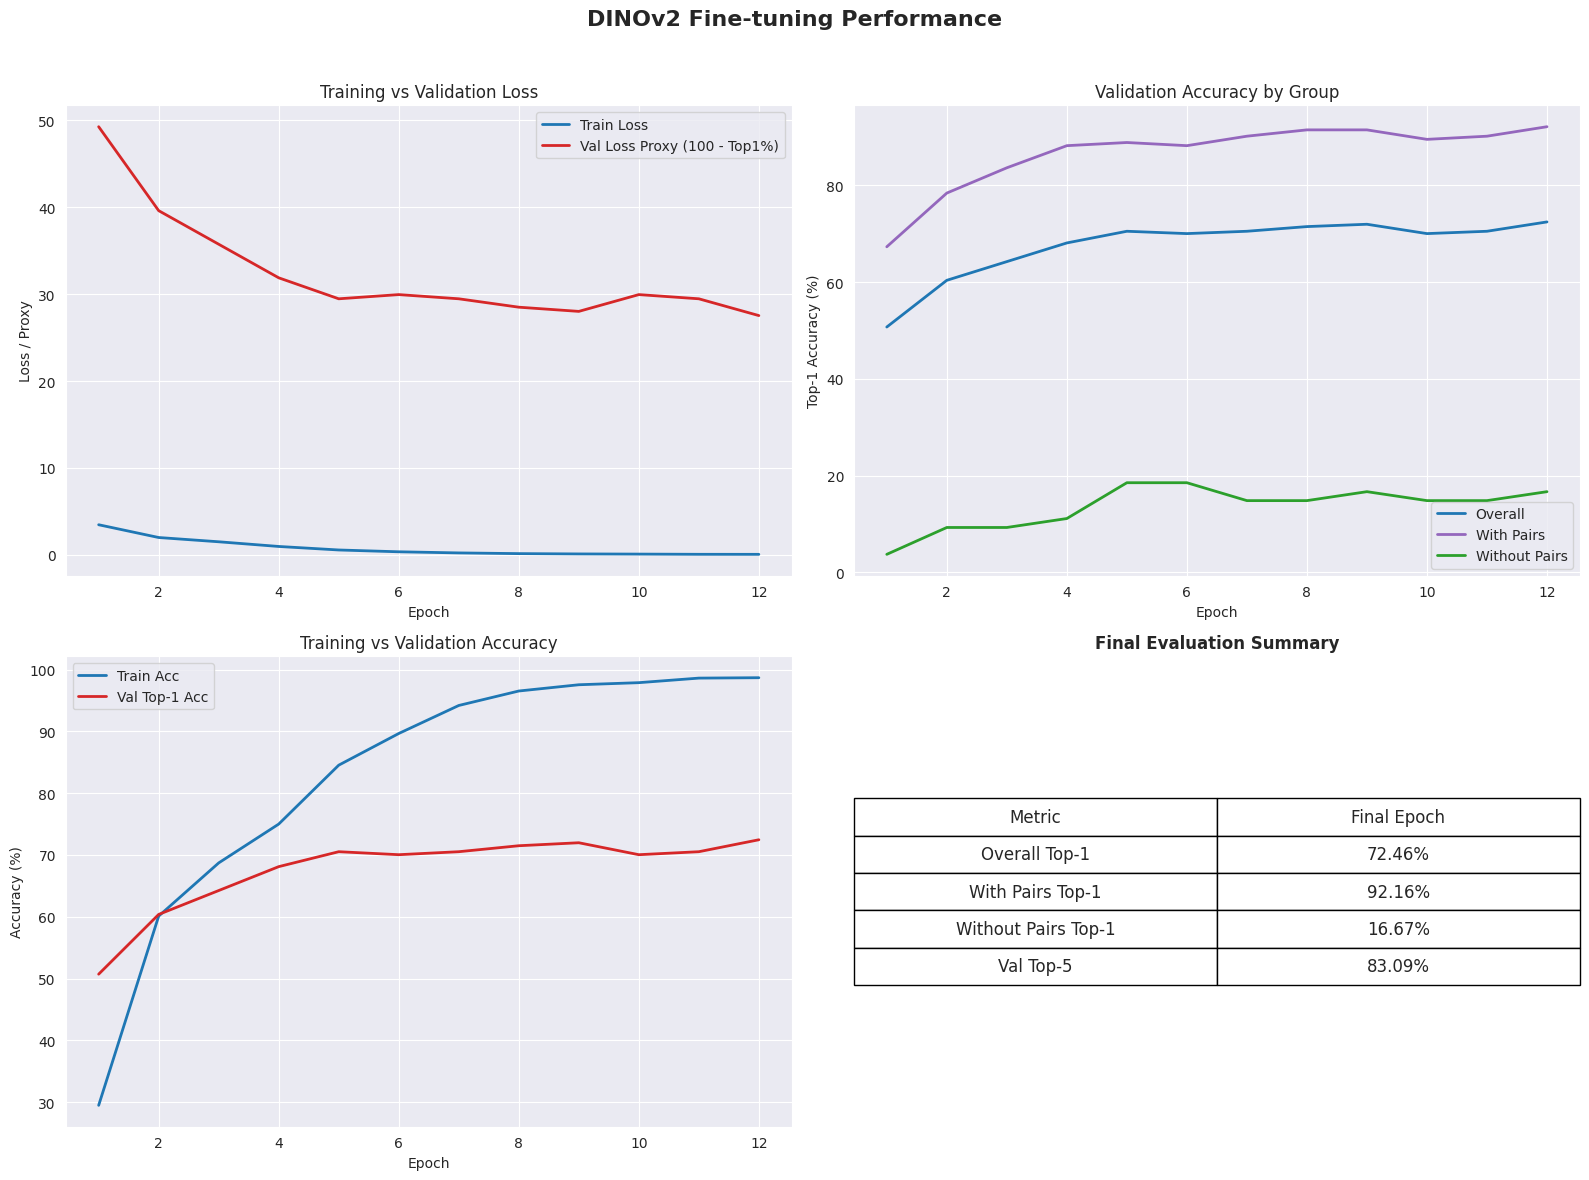

In [23]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pandas as pd
import numpy as np

# Load CSV
log_df = pd.read_csv(log_csv)  # columns: epoch, train_loss, train_acc, val_top1, val_top5, val_with_pairs, val_without_pairs, lr

epochs = log_df['epoch']
train_loss = log_df['train_loss']
train_acc = log_df['train_acc'] * 100  # convert to %
val_top1 = log_df['val_top1'] * 100
val_top5 = log_df['val_top5'] * 100
with_top1_list = log_df['val_with_top1'] * 100
without_top1_list = log_df['val_without_top1'] * 100
overall_top1_list = val_top1

sns.set_style('darkgrid')
fig = plt.figure(figsize=(16,12))
gs = GridSpec(2,2, figure=fig, width_ratios=[3,3], height_ratios=[2,2])

# -------------------------
# Plot 1: Train vs Val Loss
# -------------------------
ax0 = fig.add_subplot(gs[0,0])
ax0.plot(epochs, train_loss, label='Train Loss', color='tab:blue', linewidth=2)
ax0.plot(epochs, 100 - val_top1, label='Val Loss Proxy (100 - Top1%)', color='tab:red', linewidth=2)
ax0.set_xlabel('Epoch')
ax0.set_ylabel('Loss / Proxy')
ax0.set_title('Training vs Validation Loss')
ax0.legend()
ax0.grid(True)

# -------------------------
# Plot 2: Train vs Val Accuracy
# -------------------------
ax1 = fig.add_subplot(gs[1,0])
ax1.plot(epochs, train_acc, label='Train Acc', color='tab:blue', linewidth=2)
ax1.plot(epochs, val_top1, label='Val Top-1 Acc', color='tab:red', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Training vs Validation Accuracy')
ax1.legend()
ax1.grid(True)

# -------------------------
# Plot 3: Group-wise Accuracy
# -------------------------
ax2 = fig.add_subplot(gs[0,1])
ax2.plot(epochs, overall_top1_list, label='Overall', color='tab:blue', linewidth=2)
ax2.plot(epochs, with_top1_list, label='With Pairs', color='tab:purple', linewidth=2)
ax2.plot(epochs, without_top1_list, label='Without Pairs', color='tab:green', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Top-1 Accuracy (%)')
ax2.set_title('Validation Accuracy by Group')
ax2.legend()
ax2.grid(True)

# -------------------------
# Table of key results
# -------------------------
ax3 = fig.add_subplot(gs[1,1])
ax3.axis('off')
table_data = [
    ["Overall Top-1", f"{overall_top1_list.iloc[-1]:.2f}%"],
    ["With Pairs Top-1", f"{with_top1_list.iloc[-1]:.2f}%"],
    ["Without Pairs Top-1", f"{without_top1_list.iloc[-1]:.2f}%"],
    ["Val Top-5", f"{val_top5.iloc[-1]:.2f}%"]
]
table = ax3.table(cellText=table_data, colLabels=["Metric", "Final Epoch"], loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)
ax3.set_title("Final Evaluation Summary", fontweight='bold')

plt.suptitle("DINOv2 Fine-tuning Performance", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.96])
plt.savefig(os.path.join(PLOTS_DIR, "training_curves_subgroup_accuracy.png"), bbox_inches='tight')
plt.show()